<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/bogyung/Dacon_satellite_outlier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tf.__version__

'2.2.0-rc4'

## 데이터 받아오기

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/yeonung/train_real.npy')
test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/yeonung/test.npy')

In [4]:
#train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/train_total_32bits.npy')
#print(train.shape)
#print(train.dtype)
gmi_preci = np.load('/content/drive/My Drive/2020 Kaggle Study/data/gmi_preci_32bits.npy')
print(gmi_preci.shape)
print(gmi_preci.dtype)

(76345, 40, 40, 1)
float32


In [4]:
train.shape

(76345, 40, 40, 15)

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

## 이상치 처리

In [0]:
land_type_data = train[:,:,:,9]
land_type_data = np.where(land_type_data//100 == 2, 0.8,
                          np.where(land_type_data//100 == 3, 0.1,
                                   land_type_data//100))

In [0]:
# 1) Standard Scaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 15))
train_scaled = train_scaled.reshape(train.shape)
train_scaled[:,:,:,9] = land_type_data
train_scaled[:,:,:,-1] = gmi_preci.reshape(-1, 40, 40)  # GMI precipatation

In [0]:
# 2) Robust Scaler

from sklearn.preprocessing import RobustScaler
scaler2 = RobustScaler()
train_scaled2 = scaler2.fit_transform(train.reshape(-1, 15))
train_scaled2 = train_scaled2.reshape(train.shape)
train_scaled2[:,:,:,9] = land_type_data
train_scaled2[:,:,:,-1] = gmi_preci.reshape(-1, 40, 40)  # GMI precipatation

In [0]:
# 3) outlier del + Standard Scaler

train[:,:,:,2].reshape(-1)[train[:,:,:,2].reshape(-1)>500] = 500
train[:,:,:,3].reshape(-1)[train[:,:,:,3].reshape(-1)>500] = 500
train[:,:,:,5].reshape(-1)[train[:,:,:,5].reshape(-1)>350] = 350
train[:,:,:,6].reshape(-1)[train[:,:,:,6].reshape(-1)>350] = 350

train_scaled3 = scaler.fit_transform(train.reshape(-1,15))
train_scaled3 = train_scaled3.reshape(train.shape)
train_scaled3[:,:,:,9] = land_type_data
train_scaled3[:,:,:,-1] = gmi_preci.reshape(-1,40,40) # GMI precipatation

In [8]:
# 5, 6은 이상치 제거 효과 있음 (모든 값이 0으로 변하지는 않음)
# 0,1,2,3은 normalize하면 무조건 모든 값 0

for i in range(9):
  print(train_scaled[:,:,:,i].flatten().min(),
        train_scaled[:,:,:,i].flatten().max())
  #print(train_scaled2[:,:,:,i].flatten().min(),
  #      train_scaled2[:,:,:,i].flatten().max())
  #print(train_scaled3[:,:,:,i].flatten().min(),
  #      train_scaled3[:,:,:,i].flatten().max())

-2.203107 31.778425
-1.3007406 19.233448
-1.4864577 28.186459
-1.3494102 16.442406
-2.6388412 3.8202584
-4.3324666 20.915424
-1.5548849 5.583133
-10.524637 2.3198385
-6.16922 4.1775393


In [50]:
# 5, 6은 이상치 제거 효과 있음 (모든 값이 0으로 변하지는 않음)
# 0,1,2,3은 normalize하면 무조건 모든 값 0

for i in range(9):
  print(train_scaled[:,:,:,i].flatten().min(),
        train_scaled[:,:,:,i].flatten().max())
  print(train_scaled2[:,:,:,i].flatten().min(),
        train_scaled2[:,:,:,i].flatten().max())
  print(train_scaled3[:,:,:,i].flatten().min(),
        train_scaled3[:,:,:,i].flatten().max())

-0.0 -0.0
-0.9375 18.19
-0.0 -0.0
-0.0 -0.0
-0.383 10.7
-0.0 -0.0
-0.0 -0.0
-0.7188 17.72
-0.0 -0.0
-0.0 -0.0
-0.5303 9.35
-0.0 -0.0
-2.64 3.822
-2.188 2.9
-2.64 3.822
-0.0 -0.0
-2.953 15.445
-4.332 4.797
-0.0 -0.0
-0.7256 3.645
-1.555 3.385
-10.53 2.326
-8.28 1.518
-10.53 2.326
-6.168 4.17
-4.844 2.865
-6.168 4.17


## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer) # 32
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1) # 64
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2) # 128

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2) # 64
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1) # 32
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 10))
output_layer = build_model(input_layer, 32)

In [0]:
def create_model():
    inputs=Input((40, 40, 10))
    
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)
        
    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [0]:
model = Model(input_layer, output_layer)
#model = create_model()

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

### 1) train_scaled: RobustScaler 적용한 데이터

In [0]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train_scaled):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for file in train_scaled[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(32).prefetch(1) ############################# error나서 배치사이즈 조절: 512 -> 32
#-----------------------------------------------------------------------------
    def testGenerator():
        for file in train_scaled[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(32).prefetch(1) ################################ error나서 배치사이즈 조절: test_size -> 32
#-----------------------------------------------------------------------------

    

    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
1228/1228 [==============================] - 68s 55ms/step - loss: 0.2309 - maeOverFscore_keras: 13823585.0000 - fscore_keras: 0.0034 - val_loss: 0.2227 - val_maeOverFscore_keras: 17307562.0000 - val_fscore_keras: 0.0000e+00
Epoch 2/10
1228/1228 [==============================] - 65s 53ms/step - loss: 0.2278 - maeOverFscore_keras: 17217972.0000 - fscore_keras: 8.7879e-06 - val_loss: 0.2227 - val_maeOverFscore_keras: 17307562.0000 - val_fscore_keras: 0.0000e+00
Epoch 3/10
1228/1228 [==============================] - ETA: 0s - loss: 0.2278 - maeOverFscore_keras: 17582666.0000 - fscore_keras: 9.1678e-07

KeyboardInterrupt: ignored

### 2) train: 스케일링 안한 데이터(이상치만 제거)

In [0]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for file in train[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1) ############################# error나서 배치사이즈 조절: 512 -> 32
#-----------------------------------------------------------------------------
    def testGenerator():
        for file in train[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1) ################################ error나서 배치사이즈 조절: test_size -> 32
#-----------------------------------------------------------------------------

    
    
    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
794/794 [==============================] - 60s 76ms/step - loss: 0.3017 - maeOverFscore_keras: 3.4118 - fscore_keras: 0.5431 - val_loss: 0.2762 - val_maeOverFscore_keras: 5.0360 - val_fscore_keras: 0.3767
Epoch 2/10
794/794 [==============================] - 56s 70ms/step - loss: 0.2731 - maeOverFscore_keras: 2.7386 - fscore_keras: 0.6074 - val_loss: 0.2735 - val_maeOverFscore_keras: 4.7108 - val_fscore_keras: 0.3888
Epoch 3/10
794/794 [==============================] - 59s 74ms/step - loss: 0.2656 - maeOverFscore_keras: 2.5290 - fscore_keras: 0.6369 - val_loss: 0.2466 - val_maeOverFscore_keras: 2.9543 - val_fscore_keras: 0.5404
Epoch 4/10
794/794 [==============================] - 58s 73ms/step - loss: 0.2608 - maeOverFscore_keras: 2.4134 - fscore_keras: 0.6541 - val_loss: 0.2268 - val_maeOverFscore_keras: 2.2449 - val_fscore_keras: 0.6395
Epoch 5/10
794/794 [==============================] - 57s 72ms/step - loss: 0.2567 - maeOverFscore_keras: 2.3098 - fscore_keras:

In [0]:
## 모델 저장하기
model.save('model_scaled.h5')
!cp model_scaled.h5 '/content/drive/My Drive/2020 Kaggle Study/model/model_scaled.h5'

In [0]:
model = tf.keras.models.load_model('/content/drive/My Drive/2020 Kaggle Study/model')

OSError: ignored

In [0]:
def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['maeOverFscore_keras'], label='maeOverFscore_keras')
    plt.plot(np.arange(0, epoch), his.history['val_maeOverFscore_keras'], label='val_maeOverFscore_keras')
    plt.title(title)
    plt.xlabel(f'Epoch {epoch}')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

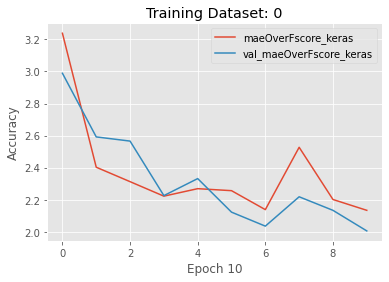

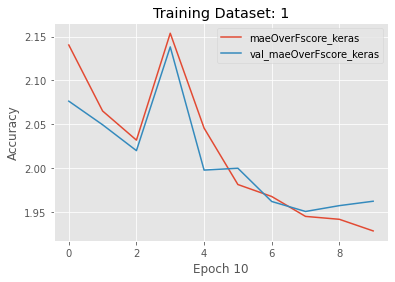

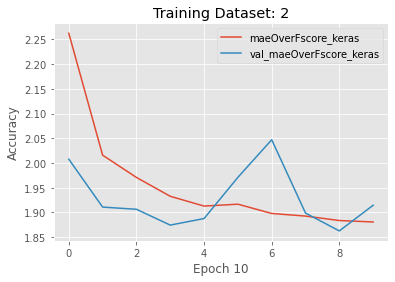

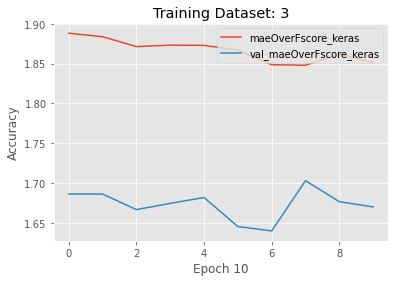

In [0]:
for dataset in range(4):
    #plot_loss(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    plot_acc(model_history[dataset], 10 , f'Training Dataset: {dataset}')


## submission 만들기

In [0]:
del train
del train_scaled

In [0]:
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
test_shape = test_submit.shape

# test_submit에 대해서도 똑같이 전처리
test_submit[:,:,:,2].reshape(-1)[test_submit[:,:,:,2].reshape(-1)>500] = 500
test_submit[:,:,:,3].reshape(-1)[test_submit[:,:,:,3].reshape(-1)>500] = 500
test_submit[:,:,:,5].reshape(-1)[test_submit[:,:,:,5].reshape(-1)>350] = 350
test_submit[:,:,:,6].reshape(-1)[test_submit[:,:,:,6].reshape(-1)>350] = 350
test_submit[:,:,:,9] = test_submit[:,:,:,9]//100
test_submit = scaler.transform(test_submit.reshape(-1, 1))
test_submit = test_submit.reshape(test_shape)

In [0]:
test_submit.shape

(2416, 40, 40, 14)

In [0]:
# 훈련에서 사용하는 0~8번 채널, ladtype 만을 뽑아내기
test_submit = test_submit[:,:,:,:10]
pred = model.predict(test_submit)
del test_submit

## submission 만들기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_scaled2.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_scaled2.csv '/content/drive/My Drive/2020 Kaggle Study/submission'